In [13]:
# Import necessary libraries
import numpy as np
import os
import torch
import time
import pymust # Assuming pymust is installed and contains dasmtx3
from vectorized_beamformer3D import vectorized_beamform
import matplotlib.pyplot as plt
from pymust import utils

In [14]:
# Load simulated data
data_dir = "simulated_data"

try:
    print(f"Loading data from '{data_dir}'...")
    xi_np = np.load(os.path.join(data_dir, 'xi.npy'))
    yi_np = np.load(os.path.join(data_dir, 'yi.npy'))
    zi_np = np.load(os.path.join(data_dir, 'zi.npy'))
    txdel3_np = np.load(os.path.join(data_dir, 'txdel3.npy'))
    param_data = np.load(os.path.join(data_dir, 'param_data.npy'), allow_pickle=True).item()
    RF3_np = np.load(os.path.join(data_dir, 'RF3.npy'))
    print("Data loaded successfully.")

    # Demodulate RF data
    print("Demodulating RF data...")
    import pymust # Import pymust here
    IQ3_np = pymust.rf2iq(RF3_np, param_data['fs'], param_data['fc'])
    print(f"I/Q data generated. Shape: {IQ3_np.shape}")

except FileNotFoundError:
    print(f"Error: Data files not found in '{data_dir}'. Please run simulate_data.py first.")
    # In a notebook, you might want to raise an error or print a message and stop execution
    raise FileNotFoundError(f"Data files not found in '{data_dir}'. Please run simulate_data.py first.")
except ImportError:
    print("Error: Required libraries (numpy, torch, pymust, matplotlib) not found. Please install them.")
    raise ImportError("Required libraries (numpy, torch, pymust, matplotlib) not found. Please install them.")
except Exception as e:
    print(f"An error occurred during data loading or demodulation: {e}")
    raise e

# Extract parameters
fs = param_data['fs']
fc = param_data['fc']
num_elements = param_data['Nelements']
element_pos_np = param_data['elements']
speed_of_sound = 1540.0 # Use default c

# Determine batch size and num_samples from the IQ data
if IQ3_np.ndim == 3:
    batch_size, num_samples, _ = IQ3_np.shape
elif IQ3_np.ndim == 2:
    num_samples, _ = IQ3_np.shape
    batch_size = 1 # Assuming single batch if no batch dim
    IQ3_np = IQ3_np[np.newaxis, :, :] # Add batch dim for consistency

# Convert all inputs to tensors (will move to device in the next cell)
IQ3_tensor = torch.from_numpy(IQ3_np).to(torch.complex64)
xi_tensor = torch.from_numpy(xi_np).to(torch.float32)
yi_tensor = torch.from_numpy(yi_np).to(torch.float32)
zi_tensor = torch.from_numpy(zi_np).to(torch.float32)
txdel3_tensor = torch.from_numpy(txdel3_np).to(torch.float32)
element_pos_tensor = torch.from_numpy(element_pos_np).to(torch.float32)

# Keep numpy versions for PyMUST comparison if needed later, or for plotting
# xi_np, yi_np, zi_np, txdel3_np, IQ3_np are already loaded

Loading data from 'simulated_data'...
Data loaded successfully.
Demodulating RF data...
I/Q data generated. Shape: (560, 1024)


In [15]:
# --- Beamforming and Timing ---

# 1. PyMUST dasmtx3 Beamforming (Keeping for comparison timing)
print("\nRunning PyMUST dasmtx3 beamforming...")
start_time_pymust = time.perf_counter()
# Need to convert inputs to match original pymust.dasmtx3 expected types if necessary
# Assuming pymust.dasmtx3 expects numpy arrays and param object
param = utils.Param()
param.update(param_data)
M3 = pymust.dasmtx3(IQ3_np[0, :, :], xi_np, yi_np, zi_np, txdel3_np, param) # Get sparse matrix for single volume
bIQ3_pymust_np = pymust.utils.applyDasMTX(M3, IQ3_np[0, :, :], xi_np.shape) # Apply matrix and get dense array for single volume
end_time_pymust = time.perf_counter()
time_pymust = end_time_pymust - start_time_pymust
print(f"PyMUST beamforming complete (single volume). Shape: {bIQ3_pymust_np.shape}")
print(f"PyMUST time (single volume): {time_pymust:.4f} seconds")



# 2. CPU PyTorch Beamforming
print("\nRunning CPU PyTorch beamforming...")
# Ensure tensors are on CPU for CPU test
IQ3_cpu_tensor = IQ3_tensor.to('cpu')
xi_cpu_tensor = xi_tensor.to('cpu')
yi_cpu_tensor = yi_tensor.to('cpu')
zi_cpu_tensor = zi_tensor.to('cpu')
txdel3_cpu_tensor = txdel3_tensor.to('cpu')
element_pos_cpu_tensor = element_pos_tensor.to('cpu')

start_time_cpu = time.perf_counter()
bIQ3_cpu_tensor = vectorized_beamform(
    IQ3_cpu_tensor, xi_cpu_tensor, yi_cpu_tensor, zi_cpu_tensor, txdel3_cpu_tensor, element_pos_cpu_tensor,
    fs, fc, num_elements, c=speed_of_sound, device='cpu'
)
end_time_cpu = time.perf_counter()
time_cpu = end_time_cpu - start_time_cpu
bIQ3_cpu_np = bIQ3_cpu_tensor.cpu().numpy() # Convert to numpy for plotting
print(f"CPU PyTorch beamforming complete. Shape: {bIQ3_cpu_np.shape}")
print(f"CPU PyTorch time: {time_cpu:.4f} seconds")

# 3. GPU PyTorch Beamforming
bIQ3_gpu_np = None
time_gpu = None
if torch.cuda.is_available():
    device = 'cuda'
    print("\nRunning GPU PyTorch beamforming...")
    # Move tensors to GPU for GPU test
    IQ3_gpu_tensor = IQ3_tensor.to(device)
    xi_gpu_tensor = xi_tensor.to(device)
    yi_gpu_tensor = yi_tensor.to(device)
    zi_gpu_tensor = zi_tensor.to(device)
    txdel3_gpu_tensor = txdel3_tensor.to(device)
    element_pos_gpu_tensor = element_pos_tensor.to(device)


    start_event = torch.cuda.Event(enable_timing=True)
    end_event = torch.cuda.Event(enable_timing=True)

    # Warm-up run
    _ = vectorized_beamform(
        IQ3_gpu_tensor, xi_gpu_tensor, yi_gpu_tensor, zi_gpu_tensor, txdel3_gpu_tensor, element_pos_gpu_tensor,
        fs, fc, num_elements, c=speed_of_sound, device=device
    )
    torch.cuda.synchronize() # Ensure warm-up is complete

    start_event.record()
    bIQ3_gpu_tensor = vectorized_beamform(
        IQ3_gpu_tensor, xi_gpu_tensor, yi_gpu_tensor, zi_gpu_tensor, txdel3_gpu_tensor, element_pos_gpu_tensor,
        fs, fc, num_elements, c=speed_of_sound, device=device
    )
    end_event.record()

    torch.cuda.synchronize() # Wait for all GPU ops and CPU transfer
    time_gpu = start_event.elapsed_time(end_event) / 1000.0 # Convert to seconds
    bIQ3_gpu_np = bIQ3_gpu_tensor.cpu().numpy() # Convert to numpy for plotting
    print(f"GPU PyTorch beamforming complete. Shape: {bIQ3_gpu_np.shape}")
    print(f"GPU PyTorch time: {time_gpu:.4f} seconds")
else:
    print("\nCUDA not available. Skipping GPU PyTorch beamforming.")



Running PyMUST dasmtx3 beamforming...
PyMUST beamforming complete (single volume). Shape: (64, 64, 128)
PyMUST time (single volume): 102.2969 seconds

Running CPU PyTorch beamforming...
Starting vectorized beamforming (PyTorch implementation) on device: cpu with JIT...
Processing grid in chunks of size (8, 16) along X and Y axes within each Z chunk...
CPU PyTorch beamforming complete. Shape: (1, 64, 64, 128)
CPU PyTorch time: 15.2555 seconds

Running GPU PyTorch beamforming...
Starting vectorized beamforming (PyTorch implementation) on device: cuda with JIT...
Processing grid in chunks of size (8, 16) along X and Y axes within each Z chunk...
Starting vectorized beamforming (PyTorch implementation) on device: cuda with JIT...
Processing grid in chunks of size (8, 16) along X and Y axes within each Z chunk...
GPU PyTorch beamforming complete. Shape: (1, 64, 64, 128)
GPU PyTorch time: 0.4914 seconds


In [16]:
# --- Display Times ---

print("\n--- Beamformer Execution Times ---")

# Check if time_pymust is defined before printing
if 'time_pymust' in locals() and time_pymust is not None:
    print(f"PyMUST time (single volume): {time_pymust:.4f} seconds")
else:
    print("PyMUST time: Not available")

# Check if time_cpu is defined before printing
if 'time_cpu' in locals() and time_cpu is not None:
    print(f"CPU PyTorch time: {time_cpu:.4f} seconds")
else:
    print("CPU PyTorch time: Not available")

# Check if time_gpu is defined before printing
if 'time_gpu' in locals() and time_gpu is not None:
    print(f"GPU PyTorch time: {time_gpu:.4f} seconds")
    if 'time_cpu' in locals() and time_cpu is not None and time_cpu > 0:
        speedup_gpu_vs_cpu = time_cpu / time_gpu
        print(f"GPU vs CPU Speedup: {speedup_gpu_vs_cpu:.2f}x")
else:
    print("GPU PyTorch time: Not available (CUDA not available or skipped)")


--- Beamformer Execution Times ---
PyMUST time (single volume): 102.2969 seconds
CPU PyTorch time: 15.2555 seconds
GPU PyTorch time: 0.4914 seconds
GPU vs CPU Speedup: 31.05x



--- Generating 2D Plots of Center Slice ---


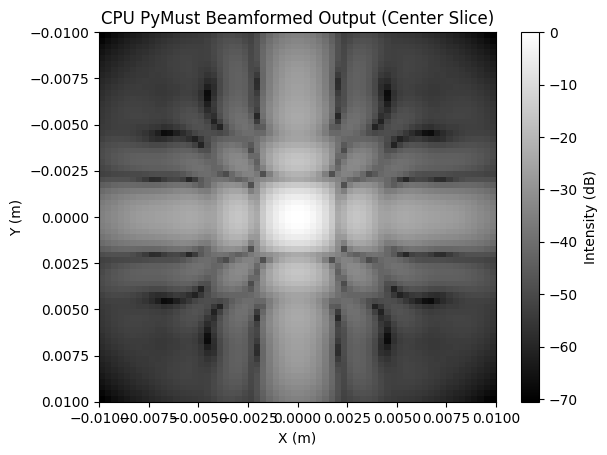

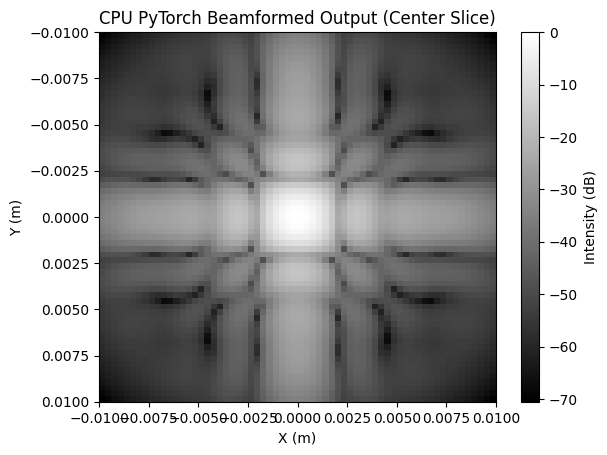

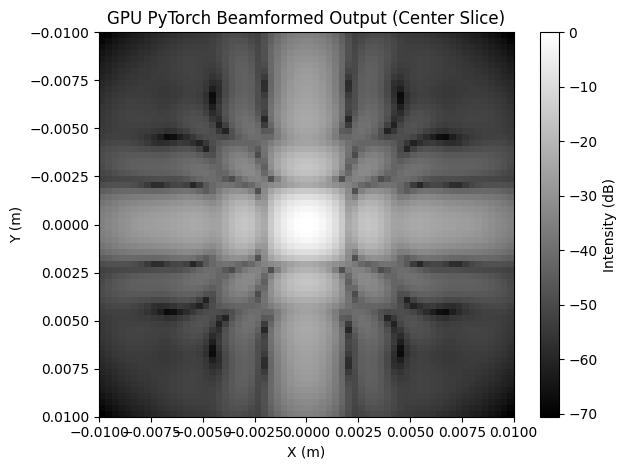

--- Plotting Complete ---


In [26]:
# --- 2D Plotting of Center Slice ---

print("\n--- Generating 2D Plots of Center Slice ---")

def plot_center_slice(data_np, xi_np, yi_np, zi_np, title):
    if data_np is None:
        print(f"Skipping plot for '{title}' as data is not available.")
        return None

    # Find the index of the center slice in the z-dimension
    center_z_index = zi_np.shape[2] // 2

    # Extract the center slice
    # Assuming data_np has a batch dimension (even if batch_size is 1)
    slice_data = data_np[0, :, :, center_z_index]
    slice_xi = xi_np[:, :, center_z_index]
    slice_yi = yi_np[:, :, center_z_index]

    # Calculate intensity in dB
    abs_data = np.abs(slice_data)
    abs_data[abs_data == 0] = np.finfo(float).eps # Avoid log10(0)
    db_data = 20 * np.log10(abs_data / np.max(abs_data))

    # Create plot
    fig, ax = plt.subplots()
    # Use extent to set the axis limits based on spatial coordinates
    im = ax.imshow(db_data, extent=[slice_xi.min(), slice_xi.max(), slice_yi.max(), slice_yi.min()], aspect='auto', cmap='gray')
    ax.set_title(title)
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    plt.colorbar(im, label='Intensity (dB)')
    return fig

# Plot the center slice for each beamformer's output
# Removed PyMUST plot as we are not comparing outputs numerically
# fig_pymust = plot_center_slice(bIQ3_pymust_np, xi_np, yi_np, zi_np, 'PyMUST Beamformed Output (Center Slice)')
fig_pymust = plot_center_slice(np.expand_dims(bIQ3_pymust_np,axis=0), xi_np, yi_np, zi_np, 'CPU PyMust Beamformed Output (Center Slice)')
fig_cpu = plot_center_slice(bIQ3_cpu_np, xi_np, yi_np, zi_np, 'CPU PyTorch Beamformed Output (Center Slice)')
fig_gpu = plot_center_slice(bIQ3_gpu_np, xi_np, yi_np, zi_np, 'GPU PyTorch Beamformed Output (Center Slice)')

plt.tight_layout()
plt.show()

print("--- Plotting Complete ---")